# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 20.10.2020

Мягкий дедлайн: 01:59MSK 02.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 01:59MSK 05.11.2020

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 9

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). 

In [3]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.metrics import hinge_loss, make_scorer
hinge_loss = make_scorer(hinge_loss, greater_is_better=False)

In [5]:
clf = make_pipeline(StandardScaler(), LinearSVC(max_iter = 1e+6))

In [6]:
tuned_parameters = [{"linearsvc__C": [0.005, 0.01, 0.1, 1, 10, 20]}]

searcher = GridSearchCV(clf, tuned_parameters, scoring=hinge_loss, cv=5)
searcher.fit(X_train, y_train)
print(searcher.best_params_)

{'linearsvc__C': 0.1}


Перебрали разные вариант с помощью кросс-валидации, получили, что лучше использовать с=0.1

На тестовой части посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Постройте ROC и PR кривые, сравните их с ответами случайного классификатора. Заметим, что с помощью `sklearn` можно посчитать обе метрики двумя разными способами - в чем их различия? Сравните результаты. 

Различия в том, что один метод считает сразу метрику, а другой строит кривую, после чего с помощью дополнительной функции (auc) можно посчитать метрику.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.svm import SVC

In [8]:
clf = make_pipeline(
    StandardScaler(), SVC(kernel="linear", C=0.1, probability=True, max_iter=1e6)
)
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, kernel='linear', max_iter=1000000.0,
                     probability=True))])

Вспомогательный источник: https://habr.com/ru/company/ods/blog/328372/

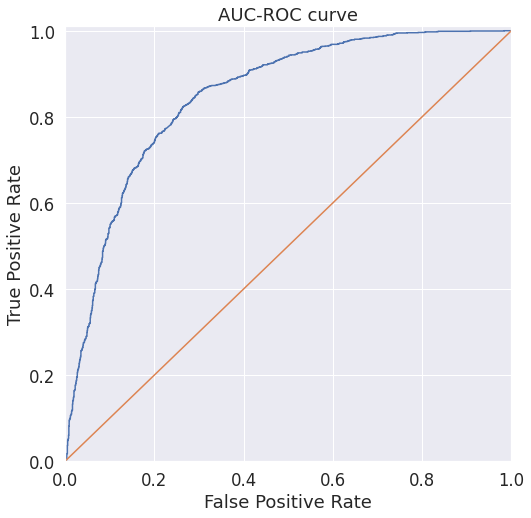

In [9]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(8, 8))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=1)
fpr = np.array(fpr).round(5)
tpr = np.array(tpr).round(5)
plt.plot(fpr, tpr, label="AUC-ROC curve ")
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC curve")
plt.show()

In [10]:
from sklearn.metrics import auc
print("auc of roc for SVM:", auc(fpr, tpr))

auc of roc for SVM: 0.8478968074500001


In [11]:
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=1)

precision = np.array(precision).round(5)
recall = np.array(recall).round(5)

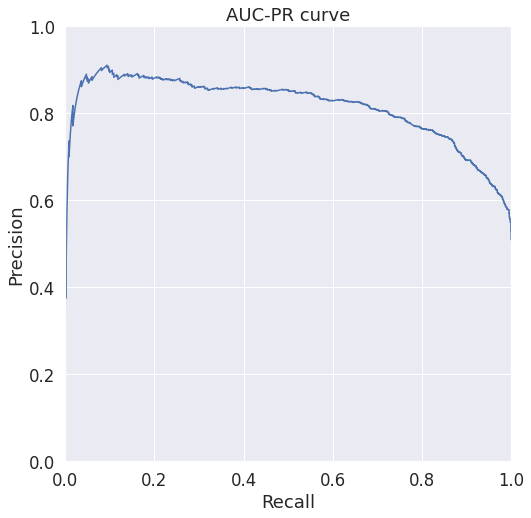

In [12]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, label="AUC-PR curve")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AUC-PR curve")
plt.show()

In [13]:
print("auc of pr for SVM:", auc(recall, precision))

auc of pr for SVM: 0.81497631015


А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

По графикам видно, что они практически одинаковые, по метрикам отличается только площадь под PR кривой. Логистическая регрессия максимизирует отступы, а SVM пытается их сделать >=1, поэтому логистическая регрессия выдаёт лучше вероятности на объектах, может быть, из-за этого было лучше предсказание на каких-то неявных объектах.

In [14]:
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 1e+6))
tuned_parameters = [{"logisticregression__C": [0.005, 0.01, 0.1, 1, 10, 20]}]

searcher = GridSearchCV(clf, tuned_parameters, cv=5)
searcher.fit(X_train, y_train)
print(searcher.best_params_)

{'logisticregression__C': 1}


In [15]:
clf = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter = 1e+6, C=1)
)
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=1000000.0))])

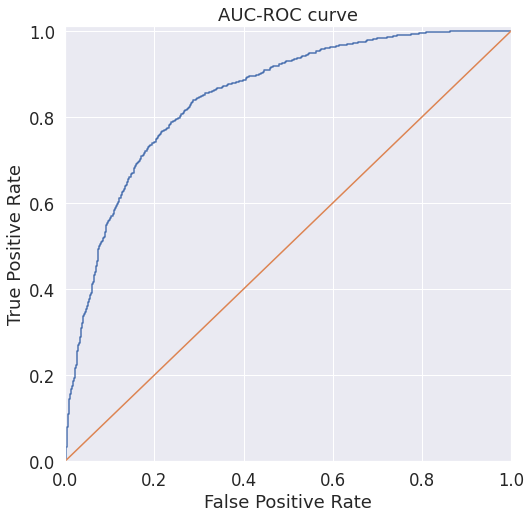

In [16]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(8, 8))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=1)
fpr = np.array(fpr).round(5)
tpr = np.array(tpr).round(5)
plt.plot(fpr, tpr, label="AUC-ROC curve ")
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC curve")
plt.show()

In [17]:
print("auc of roc for logistic regression:", auc(fpr, tpr))

auc of roc for logistic regression: 0.8478726054


In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=1)
precision = np.array(precision).round(5)
recall = np.array(recall).round(5)

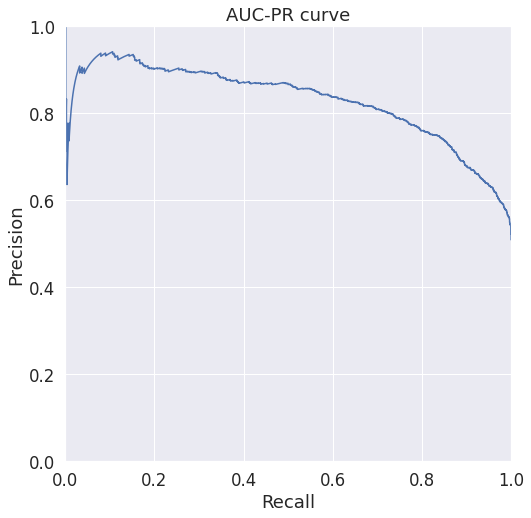

In [19]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, label="AUC-PR curve")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AUC-PR curve")
plt.show()

In [20]:
print("auc of pr for logisic regression:", auc(recall, precision))

auc of pr for logisic regression: 0.82911970555


В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [21]:
X, y = make_classification(
    n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1,
    random_state=42)

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [22]:
clf_vec = make_pipeline(
    StandardScaler(), SVC(kernel="linear", C=0.1, probability=True, max_iter=1e6)
)
clf_vec.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, kernel='linear', max_iter=1000000.0,
                     probability=True))])

In [23]:
sup_vecs = clf_vec[1].support_vectors_

Вспомогательный источники:

https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html и 

https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html

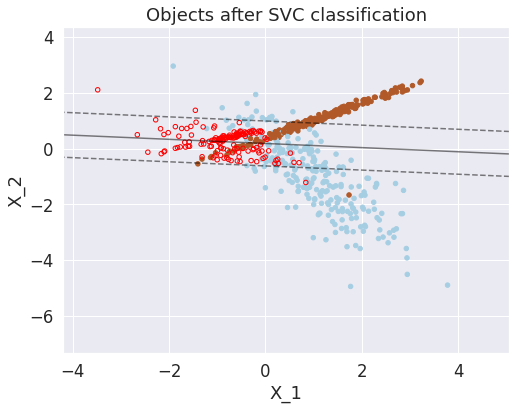

In [24]:
plt.figure(figsize=(8,6))

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0] - 2, xlim[1] + 1, 30)
yy = np.linspace(ylim[0] - 2, ylim[1] + 1, 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf_vec.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='black', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(sup_vecs[:, 0], sup_vecs[:, 1], s=20,
           linewidth=1, facecolors='none', edgecolors='red')

plt.xlabel("X_1")
plt.ylabel("X_2")
plt.title("Objects after SVC classification")
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость, а приближает в каждой точке пространства объектов правдоподобие положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [25]:
clf_vec_log = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter = 1e+6, C=1)
)
clf_vec_log.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=1000000.0))])

In [26]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf_vec_log.predict(np.c_[xx.ravel(), yy.ravel()])

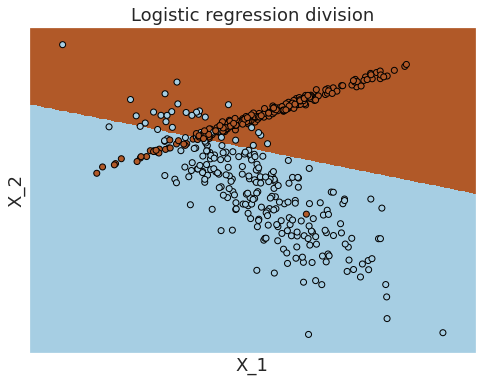

In [27]:
plt.figure(figsize=(8,6))
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, shading="auto", cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='black', cmap=plt.cm.Paired)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.xlabel("X_1")
plt.ylabel("X_2")
plt.title("Logistic regression division")
plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [28]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = (1.0 / n_bins) * i
        r = (1.0 / n_bins) * (i + 1)
        bin_middle_points.append((r + l) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    x = np.linspace(0, 1, 50)
    plt.plot(x, x, linestyle='--')
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([0.00, 1.00])
    plt.xlim([0.00, 1.00])

Сгенерируйте синтетический датасет аналогично использованному в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [29]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

clf_svm = make_pipeline(
    StandardScaler(), SVC(kernel="linear", C=0.1, probability=True, max_iter=1e6)
)
clf_svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, kernel='linear', max_iter=1000000.0,
                     probability=True))])

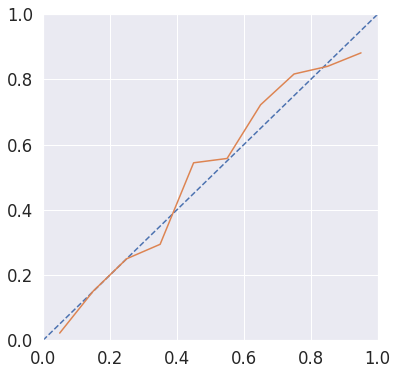

In [30]:
plot_calibration_curve(y_test, clf_svm.predict_proba(X_test)[:, 1])

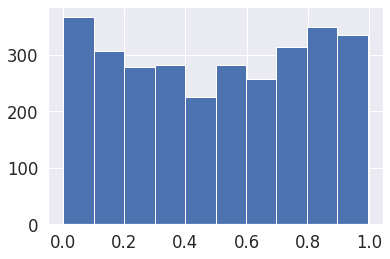

In [31]:
plt.hist(clf_svm.predict_proba(X_test)[:, 1], bins=10)
plt.show()

In [32]:
clf_log = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter = 1e+6, C=1)
)
clf_log.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=1000000.0))])

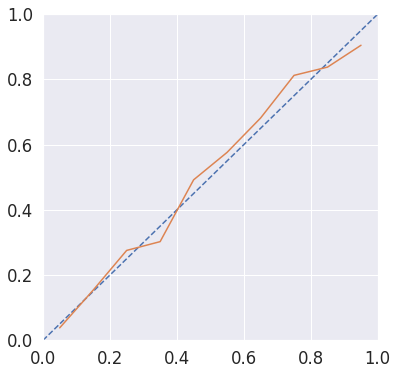

In [33]:
plot_calibration_curve(y_test, clf_log.predict_proba(X_test)[:, 1])

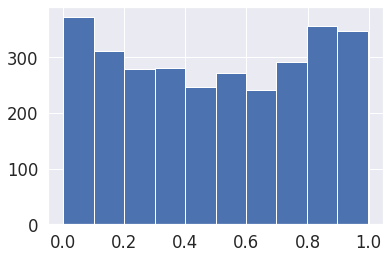

In [34]:
plt.hist(clf_log.predict_proba(X_test)[:, 1], bins=10)
plt.show()

Да, видим, что графики отличаются, в гистограмме на каждую вероятность больше объектов. Разница в том, что график калибровки учитывает настоящий класс объекта, смотрит, сколько объектов попали в положительный класс, поэтому там значения меньше.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [35]:
from sklearn.calibration import CalibratedClassifierCV

In [36]:
cccv = CalibratedClassifierCV(clf_svm, cv="prefit")
cccv.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('standardscaler',
                                                       StandardScaler()),
                                                      ('svc',
                                                       SVC(C=0.1,
                                                           kernel='linear',
                                                           max_iter=1000000.0,
                                                           probability=True))]),
                       cv='prefit')

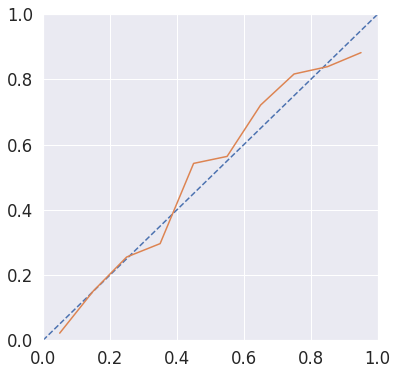

In [37]:
plot_calibration_curve(y_test, cccv.predict_proba(X_test)[:, 1])

Видим, что не особо улучшилось что-то, и так всё было более менее хорошо.

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [11]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [38]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
#!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [39]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



*Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*

В общем, тут (из описания датасета) всё написано, убираем его.

In [40]:
df["y"] = np.where(df["y"] == "yes", 1, 0)
df = df.drop(columns=["duration"])

y = df["y"]
X = df.drop(columns=["y"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

In [42]:
numeric_features = [
    "age",
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed"
]

categorical_features = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome"
]

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(
    steps=[("ordinal", OrdinalEncoder())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf_ord = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1e6)),
    ]
)

In [43]:
from timeit import default_timer as timer

start = timer()
clf_ord.fit(X_train, y_train)
end = timer()
print("Time in seconds:", end - start)

Time in seconds: 0.6928108129941393


In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, clf_ord.predict_proba(X_test)[:, 1], pos_label=1)
print("model score: %.5f" % auc(recall, precision))

model score: 0.44424


Видим, что модель такая себе. Практически наугад выдаёт ответ.

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: в этой задаче нам не страшно лишний раз позвонить клиенту, который не возьмёт кредит, на это уходят не такие большие расходы. Намного обиднее не позвонить какому-то клиенту, который взял бы большой кредит. То есть нам выгоднее допускать false positive, чем false negative. AUC ROC подходит лучше, когда важнее определять оба класса верно, а AUC PR подходит, когда нужно получить как можно больше верных объектов положительного класса, что нас и интересует.

__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [45]:
categorical_transformer = Pipeline(
    steps=[("ohe", OneHotEncoder(handle_unknown="ignore"))]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf_ord = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1e6)),
    ]
)

In [46]:
start = timer()
clf_ord.fit(X_train, y_train)
end = timer()
print("Time in seconds:", end - start)

Time in seconds: 2.817378933992586


In [47]:
precision, recall, thresholds = precision_recall_curve(y_test, clf_ord.predict_proba(X_test)[:, 1], pos_label=1)
print("model score: %.5f" % auc(recall, precision))

model score: 0.46148


Качество немного улучшилось. Но сама модель, конечно, дольше обучалась.

Как можно было заметить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?

In [48]:
def mean_encoding_basic(df, test, categorical):
    for column in categorical:
        means_category = df.groupby([column])["y"].mean().to_dict()
        df[column] =  df[column].map(means_category)
        test[column] = test[column].map(means_category)

In [49]:
df_draft = df.copy()

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ], remainder='passthrough'
)

clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1e7)),
    ]
)

In [51]:
start = timer()

y = df_draft["y"]
X = df_draft

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

X_train = X_train.copy()
X_test = X_test.copy()
mean_encoding_basic(X_train, X_test, categorical_features)

X_train = X_train.drop(columns=["y"])
X_test = X_test.drop(columns=["y"])

clf.fit(X_train, y_train)
end = timer()
print("Time in seconds:", end - start)

Time in seconds: 0.9167625529953511


In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=1)
print("model score: %.5f" % auc(recall, precision))

model score: 0.44793


Видим, что теперь быстро обучается модель, ведь там числа, а качество незначительно упало.

__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

In [78]:
##############################################################################
#Bonus task
#Сделал после всего дз, поэтому не использовал, но протестировал, всё работает.

from sklearn.base import BaseEstimator, TransformerMixin
class MeanEncodingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical):
        ''' Get list of categorical features. 
        Also creates dictionary for storing values for categorical columns.
        '''
        self.categorical = categorical
        self.means_category = {}
        
    def fit(self, X, y):
        ''' Count mean for each category.
        '''
        df = pd.concat([X, y], axis=1)
        for column in self.categorical:
            self.means_category[column] = df.groupby([column])["y"].mean().to_dict()
    
    def transform(self, X):
        ''' Change categorical values to numeric.
        '''
        df = X.copy()
        for column in self.categorical:
            df[column] =  df[column].map(self.means_category[column])
        
        return df

#Bonus task
##############################################################################

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [79]:
def mean_encoding_noisy(df, test, categorical):
    for column in categorical:
        means_category = df.groupby([column])["y"].mean().to_dict()
        for key in means_category:
            means_category[key] += np.random.randint(2)
        df[column] =  df[column].map(means_category)
        test[column] = test[column].map(means_category)

In [80]:
df_draft = df.copy()

In [81]:
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1e7)),
    ]
)

start = timer()

y = df_draft["y"]
X = df_draft

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

X_train = X_train.copy()
X_test = X_test.copy()
mean_encoding_noisy(X_train, X_test, categorical_features)

X_train = X_train.drop(columns=["y"])
X_test = X_test.drop(columns=["y"])

clf.fit(X_train, y_train)
end = timer()
print("Time in seconds:", end - start)

Time in seconds: 0.49117248300171923


In [82]:
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=1)
print("model score: %.5f" % auc(recall, precision))

model score: 0.44542


Видим, что качество модели немного ухудшилось. ОБучаться стала чуть дольше.

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [83]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [84]:
def mean_encoding_smooth(df, test, categorical):
    global_mean = (df["y"] == 1).sum() / len(df)
    for column in categorical:
        sums_category = (df.groupby([column])["y"].sum()).to_dict()
        counts_category = (df.groupby([column])["y"].count()).to_dict()
        for key in sums_category:
            sums_category[key] += (10 * global_mean) / (counts_category[key] + 10)
        df[column] = df[column].map(sums_category)
        test[column] = test[column].map(sums_category)

In [85]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ], remainder='passthrough'
)
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1e6)),
    ]
)

In [86]:
df_draft = df.copy()

In [87]:
start = timer()

y = df_draft["y"]
X = df_draft

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

X_train = X_train.copy()
X_test = X_test.copy()
mean_encoding_smooth(X_train, X_test, categorical_features)


X_train = X_train.drop(columns=["y"])
X_test = X_test.drop(columns=["y"])

clf.fit(X_train, y_train)
end = timer()

print("Time in seconds:", end - start)

Time in seconds: 3.2561608130054083


In [88]:
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
print("model score: %.5f" % auc(recall, precision))

model score: 0.42789


Видим, что опять, время увеличилось, качество чуть ухудшилось.

__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [89]:
numeric_features = [
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed"
]

categorical_features = [
    "age",
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome"
]
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ], remainder='passthrough'
)
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1e6)),
    ]
)

In [90]:
df_draft = df.copy()
start = timer()

y = df_draft["y"]
X = df_draft

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

X_train = X_train.copy()
X_test = X_test.copy()
mean_encoding_smooth(X_train, X_test, categorical_features)


X_train = X_train.drop(columns=["y"])
X_test = X_test.drop(columns=["y"])

clf.fit(X_train, y_train)
end = timer()

print("Time in seconds:", end - start)

Time in seconds: 5.9363509620015975


In [91]:
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
print("model score: %.5f" % auc(recall, precision))

model score: 0.42992


Здорово, по сравнению с последним результатом это всё-таки чуть лучше. Но времени потратили больше.

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [92]:
df_draft = df.copy()

In [93]:
months = {
    "dec": 12,
    "jan": 1,
    "feb": 2,
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
    "sep": 9,
    "oct": 10,
    "nov": 11,
}

weekdays = {"mon": 0, "tue": 2, "wed": 3, "thu": 4, "fri": 5}

In [94]:
df_draft["day_of_week"] = df_draft["day_of_week"].map(weekdays)
df_draft["month"] = df_draft["month"].map(months)

In [95]:
numeric_features = [
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
    "month",
    "day_of_week"
]

categorical_features = [
    "age",
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "poutcome"
]
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ], remainder='passthrough'
)
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1e6)),
    ]
)

In [96]:
start = timer()

y = df_draft["y"]
X = df_draft

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

X_train = X_train.copy()
X_test = X_test.copy()
mean_encoding_smooth(X_train, X_test, categorical_features)


X_train = X_train.drop(columns=["y"])
X_test = X_test.drop(columns=["y"])

clf.fit(X_train, y_train)
end = timer()

print("Time in seconds:", end - start)

Time in seconds: 1.9213404259935487


In [97]:
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
print("model score: %.5f" % auc(recall, precision))

model score: 0.42207


Теперь видим, что качество ухудшилось. Но зато улучшилось время. В общем, в этой ситуации месяцы и дни недели лучше использовать как категориальные признаки.

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ счётчики могут показывать больше смысла для каких-то категорий, потому что one-hot просто заменяет признаки на бинарные, также они экономят память. Но при этом счётчики могут ухудшить качество, без верного подбора шума и сглаживания.

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про банковский телефонный маркетинг.

In [300]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df["y"] = np.where(df["y"] == "yes", 1, 0)

X = df.drop(columns=['duration', 'y'])
y = df.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [301]:
numeric_features = [
    "age",
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed"
]

categorical_features = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome"
]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])
column_transformer.fit(X_train, y_train)

ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'day_of_week', 'poutcome']),
                                ('scaling', StandardScaler(),
                                 ['age', 'campaign', 'pdays', 'previous',
                                  'emp.var.rate', 'cons.price.idx',
                                  'cons.conf.idx', 'euribor3m',
                                  'nr.employed'])])

In [302]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (32950, 19)
Size after OneHot: (32950, 62)


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [303]:
clf = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        ("classifier", LogisticRegression(max_iter=1e6)),
    ]
)

In [304]:
clf.fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=1)
print("model score: %.5f" % auc(recall, precision))

value_to_remember = auc(recall, precision)

model score: 0.44732


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [305]:
start = timer()

clf.fit(X_train, y_train)
indices = np.abs(clf[1].coef_).argsort()[:,-40:]
indices = indices.reshape(40,)
X_train_temp = column_transformer.transform(X_train)[:, indices]
X_test_temp = column_transformer.transform(X_test)[:, indices]

end = timer()
print("Time in seconds:", end - start)

Time in seconds: 2.938924570000381


In [306]:
logreg_cool = LogisticRegression(max_iter=1e6)
logreg_cool.fit(X_train_temp, y_train)

LogisticRegression(max_iter=1000000.0)

In [307]:
precision, recall, thresholds = precision_recall_curve(
    y_test, logreg_cool.predict_proba(X_test_temp)[:, 1], pos_label=1
)
print("model score: %.5f" % auc(recall, precision))

model score: 0.44969


Как же здорово, качество чуть-чуть улучшилось, это очень здорово, какую же гениальную тактику мы применили, просто убрали 20 признаков, но даже выиграли от этого!

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось? 

Получилось, что признаки я всегда скалировал до этого, поэтому в этот раз скалировать не будем.

In [308]:
not_cool_column_transformer = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="ignore"), categorical_features),],
    remainder="passthrough",
)
not_cool_column_transformer.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'day_of_week', 'poutcome'])])

In [309]:
X_train_temp = not_cool_column_transformer.transform(X_train)
X_test_temp = not_cool_column_transformer.transform(X_test)
logreg_not_cool = LogisticRegression(max_iter=1e6)
logreg_not_cool.fit(X_train_temp, y_train)

LogisticRegression(max_iter=1000000.0)

In [310]:
not_cool_indices = np.abs(logreg_not_cool.coef_).argsort()[:,-40:]
not_cool_indices = not_cool_indices.reshape(40,)
X_train_temp = X_train_temp[:, not_cool_indices]
X_test_temp = X_test_temp[:, not_cool_indices]

In [311]:
logreg_not_cool.fit(X_train_temp, y_train)
precision, recall, thresholds = precision_recall_curve(
    y_test, logreg_not_cool.predict_proba(X_test_temp)[:, 1], pos_label=1
)
print("model score: %.5f" % auc(recall, precision))

model score: 0.44537


Какой же ужас, видим, что всё ужасно и всё плохо, качество ухудшилось, потому что мы не скалировали признаки, всё очень плохо. Делаем вывод, что надо скалировать признаки.

Видим, что признаки отобрались разные:

In [312]:
set(indices) == set(not_cool_indices)

False

<h1><center>ЗАГАДКА ЖАКА ФРЕСКО! НА РЕШЕНИЕ 30 СЕКУНД </center></h1>

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы (а где вопрос?). Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [313]:
X_train_temp = not_cool_column_transformer.transform(X_train)
X_test_temp = not_cool_column_transformer.transform(X_test)

In [314]:
scaler = StandardScaler()
X_train_temp = scaler.fit_transform(X_train_temp)
X_test_temp = scaler.transform(X_test_temp)

In [315]:
logreg_chaotic = LogisticRegression(max_iter=1e6)
logreg_chaotic.fit(X_train_temp, y_train)

LogisticRegression(max_iter=1000000.0)

In [316]:
dummy_indices = np.abs(logreg_chaotic.coef_).argsort()[:,-40:]
dummy_indices = dummy_indices.reshape(40,)

Список поменялся:

In [317]:
print(set(dummy_indices) == set(not_cool_indices))
print(set(dummy_indices) == set(indices))

False
False


In [319]:
X_train_temp = X_train_temp[:, dummy_indices]
X_test_temp = X_test_temp[:, dummy_indices]

In [320]:
logreg_chaotic.fit(X_train_temp, y_train)
precision, recall, thresholds = precision_recall_curve(
    y_test, logreg_chaotic.predict_proba(X_test_temp)[:, 1], pos_label=1
)
print("model score: %.5f" % auc(recall, precision))

model score: 0.44818


Вообще, видим, что результат всё равно лучше, чем совсем без нормализации, но хуже, чем когда мы оставили их бинарными. В принципе, думаю, что нет смысла этого делать, потому что признак категориальный, поэтому те числа означают категорию, а не какое-то качество/количество/что-то измеримое, поэтому их среднее не имеет смысла и нет смысла в стандартизации.

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [449]:
X_train_temp = column_transformer.transform(X_train)
X_filter = np.insert(X_train_temp, 62, y_train, axis=1)
X_filter = pd.DataFrame(X_filter)

In [450]:
indices_t = []

In [451]:
start = timer()

counts = X_filter.groupby([62]).count().reset_index()
means = X_filter.groupby([62]).mean().reset_index()
stds = X_filter.groupby([62]).std().reset_index()

for i in range(0, 62):
    t = np.abs(means[i][1] - means[i][0])
    temp = counts[i][1]*(stds[i][1])**2 + counts[i][0]*(stds[i][0])**2
    temp /= counts[i][1] + counts[i][0]
    t /= np.sqrt(temp)
    indices_t.append(t)
    
indices_t = np.array(indices_t)
indices_t = indices_t.argsort()[-40:]

end = timer()
print("Time in seconds:", end - start)

Time in seconds: 0.09509289701236412


In [457]:
X_train_temp = column_transformer.transform(X_train)[:, indices_t]
X_test_temp = column_transformer.transform(X_test)[:, indices_t]

In [458]:
logreg_filter = LogisticRegression(max_iter=1e6)
logreg_filter.fit(X_train_temp, y_train)
precision, recall, thresholds = precision_recall_curve(
    y_test, logreg_filter.predict_proba(X_test_temp)[:, 1], pos_label=1
)
print("model score: %.5f" % auc(recall, precision))

model score: 0.45122


Невероятно, качество немного улучшилось, этот метод оказался ещё лучше предыдущих для наших данных и данной модели.

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [545]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import average_precision_score

In [568]:
def my_auc_pr(y_test, y_pred):
    precision, recall, thresholds = precision_recall_curve(
    y_test, y_pred, pos_label=1)
    return auc(recall, precision)

auc_pr = make_scorer(my_auc_pr, needs_proba=True, greater_is_better=True)

In [569]:
selector = RFECV(
    LogisticRegression(max_iter=1e6),
    min_features_to_select=40,
    step=1,
    scoring=auc_pr,
    cv=2,
)

In [570]:
X_train_temp = column_transformer.transform(X_train)
X_test_temp = column_transformer.transform(X_test)

In [571]:
start = timer()
selector.fit(X_train_temp, y_train)
end = timer()
print("Time in seconds:", end - start)

Time in seconds: 80.84784567300812


In [572]:
precision, recall, thresholds = precision_recall_curve(
    y_test, selector.predict_proba(X_test_temp)[:, 1], pos_label=1
)
print("model score: %.5f" % auc(recall, precision))

model score: 0.44747


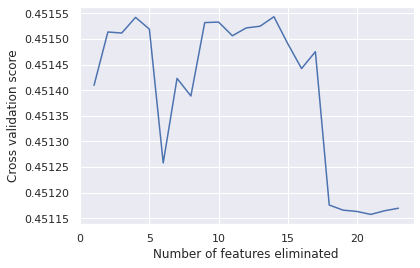

In [594]:
sns.set(font_scale=1)
plt.xlabel("Number of features eliminated")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.xticks()
plt.show()

In [595]:
print(selector.n_features_)

53


Видим, что оптимальное количество признаков = 53. Дальше качество сильно ухудшается.

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [663]:
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    X_train, y_train, test_size=0.5, random_state=777, stratify=y_train
)

In [664]:
X_train_temp = column_transformer.transform(X_train_temp)
X_test_temp = column_transformer.transform(X_test_temp)

In [667]:
features_good = []
total_result = []
logreg = LogisticRegression(max_iter=1e6)

In [668]:
start = timer()

for j in range(0, 40):
    results = {}
    for i in range(0, 62):
        if i in features_good:
            continue

        logreg.fit(X_train_temp[:, features_good + [i]], y_train_temp)
        precision, recall, thresholds = precision_recall_curve(
            y_test_temp,
            logreg.predict_proba(X_test_temp[:, features_good + [i]])[:, 1],
            pos_label=1,
        )
        results[i] = auc(recall, precision)

    max_key = max(results, key=results.get)
    features_good.append(max_key)
    total_result.append(results[max_key])

end = timer()
print("Time in seconds:", end - start)

Time in seconds: 377.91839293099474


Ну уже видно, что способ не лучший, компьютер просто летал по всей комнате на своих вентиляторах, мне это не понравилось. И ждать долго.

In [673]:
X_train_temp = column_transformer.transform(X_train)
X_test_temp = column_transformer.transform(X_test)

In [674]:
logreg.fit(X_train_temp[:, features_good], y_train)
precision, recall, thresholds = precision_recall_curve(
    y_test, logreg.predict_proba(X_test_temp[:, features_good])[:, 1], pos_label=1
)
print("model score: %.5f" % auc(recall, precision))

model score: 0.45287


Качество улучшилось, это неплохо, но у нас было и так неплохое с помощью очень быстрого способа, а этот очень трудоёмкий, слишком много затрат для такого улучшения.

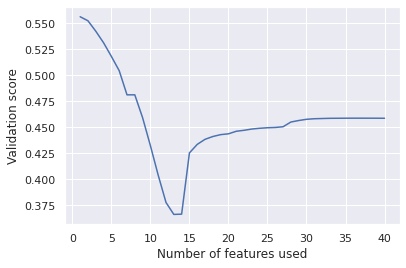

In [681]:
plt.xlabel("Number of features used")
plt.ylabel("Validation score")
plt.plot(range(1, 41), total_result)
plt.show()

Мы видим странное явление, что при небольшом количестве признаков мы могли бы получить ещё большее хорошее качество, хотя потом оно резко ухудшилось, а к 30+ признакам стабилизировалось. Давайте ради любопытства запустим обучение на 3 признаках.

In [684]:
logreg.fit(X_train_temp[:, features_good[:3]], y_train)
precision, recall, thresholds = precision_recall_curve(
    y_test, logreg.predict_proba(X_test_temp[:, features_good[:3]])[:, 1], pos_label=1
)
print("model score: %.5f" % auc(recall, precision))

model score: 0.54457


Интересный результат. Видим, что можно иногда использовать мало, но полезных признаков, получили даже что-то хорошее.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** На мой взляд лучше всего себя показал метод фильтрации, также он был самым быстрым и выдал неплохое качество. Неплохой метод также с оцениванием весов, но только после стандартизации числовых признаков, это важно, работает отностильно быстро. Метод обёркти с постепенным удалением признаков в этой ситуации работал не очень хорошо, занял много времени, но действительно выдал хорошее качество.

Думаю, что метод обёртки будет плохим на практике, если там очень много признаков и сложные модели, потому что тогда слишком долго ждать результата. Ещё он может быть не очень хорошим, если мало данных, потому что его нужно обучать и отлаживать на трейне и валиде.

Но при этом именно он показал интересный результат, что иногда маленькое количество признаков может улучшить качество.

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [16]:
#your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [17]:
#your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [18]:
#your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [19]:
#your code here

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [20]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [21]:
#your code here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [22]:
#your code here

Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [23]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Ничего, я проспал его.